# Using ICA to reduce artefacts

This section will show to use an independent component analysis (ICA) approach to suppress ocular and heart artifacts. This will be done by first performing an ICA decomposition of the data after which the components reflecting the artifacts are identified manually. As a last step the artifact components are 'projected out'.

### Preparation

Important the relevant Python modules:

In [16]:
import os.path as op
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from mne.preprocessing import ICA

import mne

Set the local paths to the data:

In [2]:
data_path = r'D:\CogitateExp1\SA109'
result_path = r'D:\CogitateResults\exp1\SA109'
file_name = ['SA109_run1','SA109_run2','SA109_run3','SA109_run4','SA109_run5']

### Resampling and filtering of the raw data
In order to do the ICA decomposition efficiently and keep all sub-data sets in memory we will first down-sample the data. We will use the datasets in which SSS was applied. We will then apply the resample function to downsample the data to 200 Hz and then apply a bandpass filter. The 1 Hz highpass filter is important for removing slow drifts which otherwise would make the ICA decomposition less efficient. After these operation the data sets are concatenated (using concatenate_raws) such that the ICA can be formed on the data sets in one hit.

In [5]:
for subfile in range(0, 5):
    path_file = os.path.join(result_path,file_name[subfile]+'sss.fif') 
    print(path_file)

    raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)
    raw_resmpl = raw.copy().pick_types(meg=True,eog=True,ecg=True)
    raw_resmpl.resample(200)
    raw_resmpl.filter(1, 40)  
    if subfile == 0:
        raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
    else:
        raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl])
del raw_resmpl

D:\CogitateResults\exp1\SA109\SA109_run1sss.fif
Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run1sss.fif...


<ipython-input-5-842ddb4fc361>:5: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run1sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 19000 ... 860999 =     19.000 ...   860.999 secs
Ready.
Reading 0 ... 841999  =      0.000 ...   841.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

D:\CogitateResults\exp1\SA109\SA109_run2sss.fif
Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run2sss.fif...


<ipython-input-5-842ddb4fc361>:5: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run2sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 18000 ... 840999 =     18.000 ...   840.999 secs
Ready.
Reading 0 ... 822999  =      0.000 ...   822.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

D:\CogitateResults\exp1\SA109\SA109_run3sss.fif
Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run3sss.fif...


<ipython-input-5-842ddb4fc361>:5: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run3sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 15000 ... 809999 =     15.000 ...   809.999 secs
Ready.
Reading 0 ... 794999  =      0.000 ...   794.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

D:\CogitateResults\exp1\SA109\SA109_run4sss.fif
Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run4sss.fif...


<ipython-input-5-842ddb4fc361>:5: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run4sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 36000 ... 843999 =     36.000 ...   843.999 secs
Ready.
Reading 0 ... 807999  =      0.000 ...   807.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

D:\CogitateResults\exp1\SA109\SA109_run5sss.fif
Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run5sss.fif...


<ipython-input-5-842ddb4fc361>:5: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run5sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 20000 ... 822999 =     20.000 ...   822.999 secs
Ready.
Reading 0 ... 802999  =      0.000 ...   802.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)



### Applying the ICA algorithm
Now apply the ICA algorithm. We have chosen for the fastica approach:

In [17]:
ica = ICA(method='fastica',
    random_state=97,
    n_components=30,
    verbose=True)

ica.fit(raw_resmpl_all,
    verbose=True)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 115.0s.


<ICA | raw data decomposition, fit (fastica): 814200 samples, 30 components, channels used: "mag"; "grad">

### Identifying the ICA components reflecting the artifacts
To plot the examples for the time-traces of the ICA components use the plot_sources function. Use the left/right arrow-keys to scroll through the data and the up/down arrow-keys to scroll through the components:
    

In [ ]:
ica.plot_sources(raw_resmpl_all,title='ICA');

The last three traces show the horizontal and vertical EOG (EOG001 and EOG002) as well as the electrocardiogram (ECG003).

**Question 1:** Estimate the frequency of the hear rate

**Question 2:** Identify the saccades in EOG001

When inspecting the traces and comparing them to the EOG and ECG, it is clear that ICA002 reflect eye-blinks as measured most strongly by the vertical EOG (EOG001). Component ICA018 reflects saccades as mainly measured by the horizontal EOG (EOG002). Finally, ICA021 reflect the ECG (EOG003). This order of ICA components is specific to this data set. For other data sets the components will come in a different order. Therefore the components associated with artifacts have to be identified manually.

To show the topographies of the each of the ICA components write:

In [ ]:
ica.plot_components();

These plots show the topography associated with the magnetometers as they are are most straight forward to interpret. The topography of ICA002 looks like a classical eye-blink artifacts with strong activity over frontal left and right sensors of opposite polarity. The frontal negativity of ICA018 is associated with saccades. ICA021 looks like a typical ECG artifact as observed by the strong activity in the rim sensors stemming from the magnetic field circling the heart.

How many components should in general be removed? As a rule of thumb no more than a handful. Typically only remove components which clearly reflect a physiological artifact. Removing too many components might remove brain activity as well.

**Question 3:** Which component(s) might reflect the human alpha band activity? Base your argument both on the traces and topographies.

### Reducing the artifacts by applying the projections
The aim is to 'project out' the ICA components associated with the ocular and cardiac artifacts. This will be done by applying the ICA projections generated by *ica.exclude* to the original raw data which will be loaded again by looping over the sub-files. After the ICA projections have been applied (*ica.apply*) the data will be saved.

In [ ]:
# Set the 3 components to exclude
ica.exclude = [2, 18, 21]

# Loop over the subfiles 
for subfile in range(0, 5):
    path_file = os.path.join(result_path,file_name[subfile]+'sss.fif') 
    path_outfile = os.path.join(result_path,file_name[subfile]+'sss_ica.fif') 

    raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)

    ica.apply(raw)

    raw.save(path_outfile,overwrite=True) 

### Plotting the data to check the artifact reduction

We will here examine some of the traces from one of the subfiles (#4) to demonstrate the artifact reduction. First reload the files.

In [7]:
subfile = 4
path_file = os.path.join(result_path,file_name[subfile]+'sss.fif') 
path_outfile = os.path.join(result_path,file_name[subfile]+'sss_ica.fif') 

raw     = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)
raw_ica = mne.io.read_raw_fif(path_outfile,allow_maxshield=True,verbose=True,preload=True)

Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run5sss.fif...


<ipython-input-7-c10d5234b1f3>:5: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run5sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw     = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 20000 ... 822999 =     20.000 ...   822.999 secs
Ready.
Reading 0 ... 802999  =      0.000 ...   802.999 secs...
Opening raw data file D:\CogitateResults\exp1\SA109\SA109_run5sss_ica.fif...


<ipython-input-7-c10d5234b1f3>:6: RuntimeWarning: This filename (D:\CogitateResults\exp1\SA109\SA109_run5sss_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw_ica = mne.io.read_raw_fif(path_outfile,allow_maxshield=True,verbose=True,preload=True)


    Range : 20000 ... 822999 =     20.000 ...   822.999 secs
Ready.
Reading 0 ... 802999  =      0.000 ...   802.999 secs...


Define a few frontal magnetometers to examine and include the EOG sensors:

In [8]:
chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411', 'EOG001','EOG002']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]

Then plot the data prior to the ICA projections were applied. Use the arrow button to scroll through the trials.

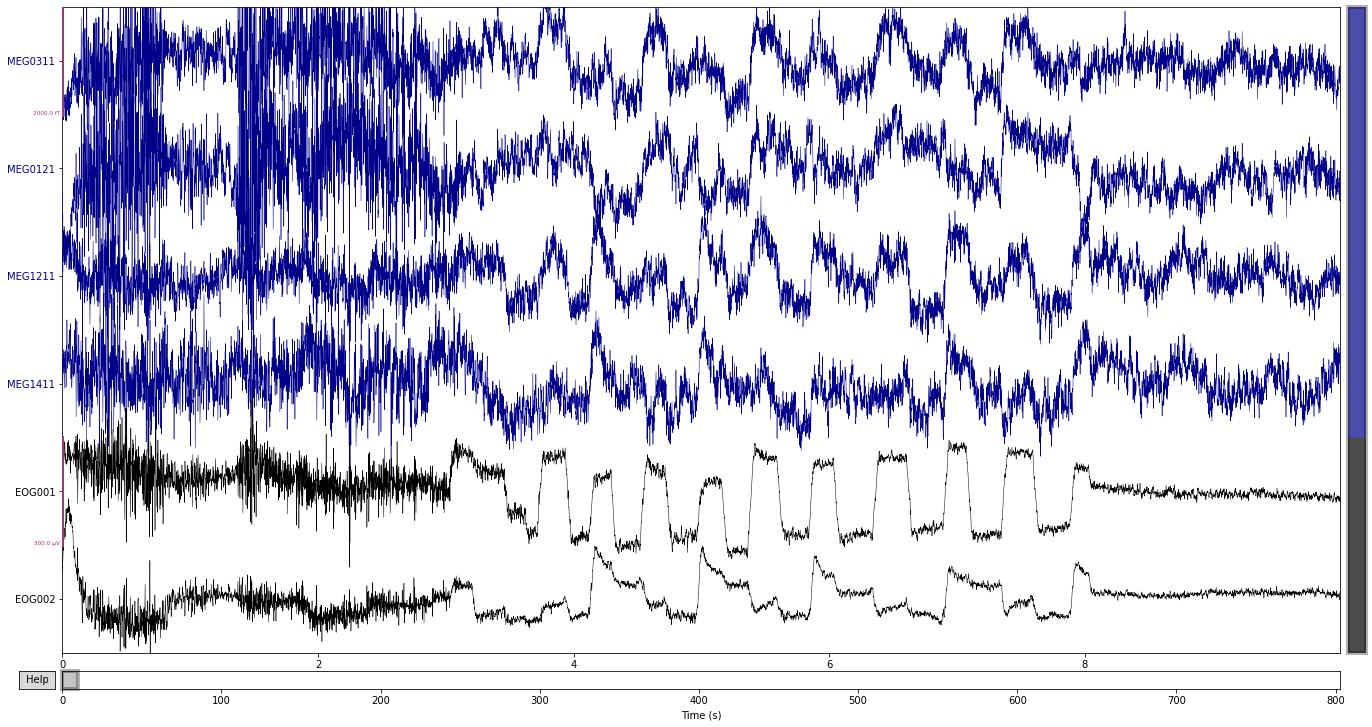

In [10]:
raw.plot(order=chan_idxs);

Above shows the raw traces prior to the application of the ICA projections. Note the ocular artifacts in the MEG data at e.g. ~480 ms.

Then plot the same traces after the application of the ICA projections:

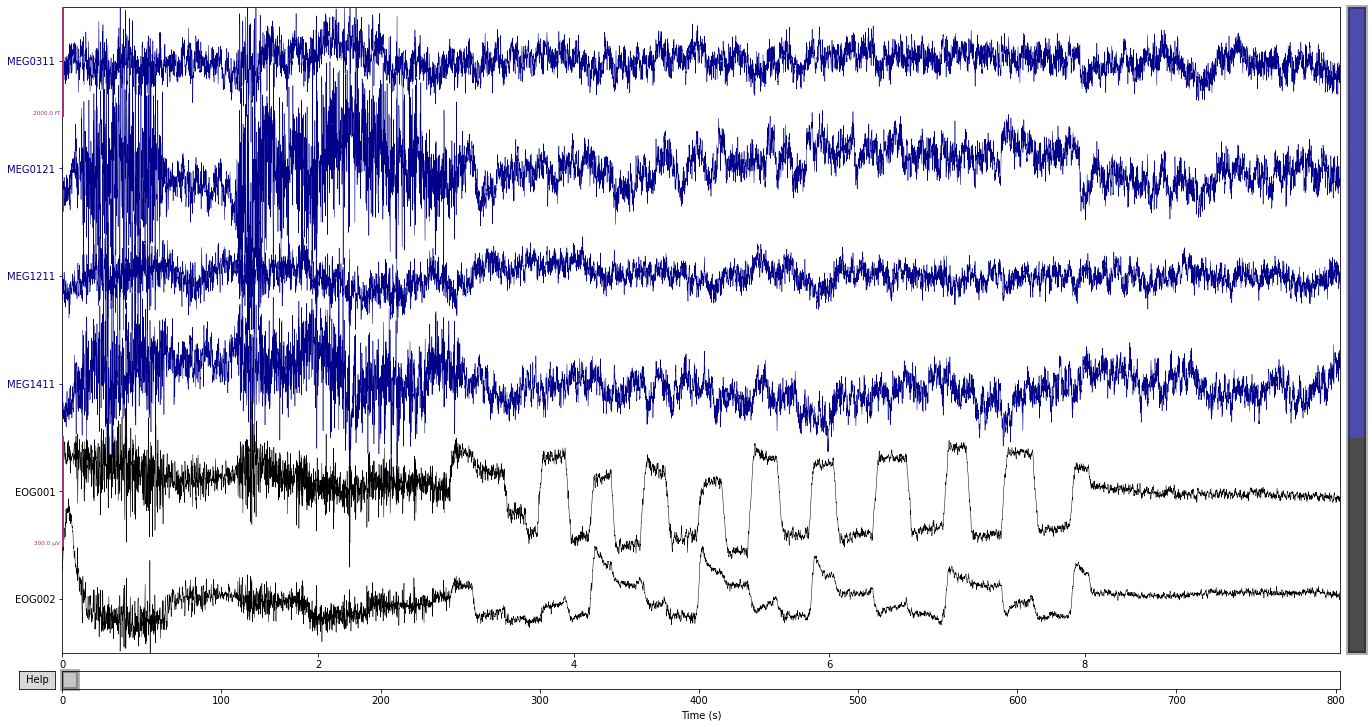

In [11]:
raw_ica.plot(order=chan_idxs);

As seen in the plot above the ocular artifacts are clearly reduced.